# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

%cd drive/MyDrive/inv/investments_project

Mounted at /content/drive
/content/drive/MyDrive/inv/investments_project


---
# Utils

## Imports

In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import wrds
import seaborn as sns

In [ ]:
# WRDS connection Set up

# Your Username here
username = "maallard"

db=wrds.Connection(wrds_username=username)
db.create_pgpass_file()

Loading library list...
Done


## Helper Functions

---
# The Data

**Download:**
- Monthly stock returns from CRSP from January 1, 1964, to December 31, 2023, for all common stocks traded on the NYSE and AMEX.
- The value-weighted CRSP market return and 1-month T-bill returns as a risk-free rate.

In [ ]:
### Download and format data

#---------------------------------------------
# Risk Free Rate
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm
            from crsp.tfz_mth_rf
            where kytreasnox = 2000001
            and mcaldt>='1964-01-01'
            and mcaldt<='2023-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi
                where date>='1964-01-01' and date<='2023-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns
#---------------------------------------------

stock_data = db.raw_sql("""
                    select a.permno, a.date, a.ret, a.shrout, a.prc, b.siccd
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1964' and '12/31/2023'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date'])
stock_data = stock_data.rename(columns={'ret':'Rn'})


#---------------------------------------------
# Merge Data
#---------------------------------------------

# Merge all data
merged_data = pd.merge(stock_data, Rm, on='date')
merged_data = pd.merge(merged_data, Rf, on='date')

# Save CSV
merged_data.to_csv('merged_stock_data.csv', index=False)

## Load and Prepare DATA

In [ ]:
data = pd.read_csv("../data/merged_stock_data.csv")

In [ ]:
# CLEAN
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['permno', 'date']) # Sort the data by 'permno' and 'date'
data['mcap'] = np.abs(data['prc']) * data['shrout'] # Market capitalization
data['mcap_l'] = data.groupby(['permno'])['mcap'].shift(1) # Lagged market capitalization
data['Rn_f'] = data.groupby(['permno'])['Rn'].shift(-1) # Future stock return
# CST col
data['const'] = 1
# Excess returns
data['Rn_e'] = data['Rn'] - data['rf']
data['Rm_e'] = data['Rm'] - data['rf']
# Market capitalization weight
data['w_m'] = data['mcap_l'] / data.groupby(['date'])['mcap_l'].transform('sum')

# Drop na rows
data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e']).copy()

data.head()

,permno,date,Rn,shrout,prc,siccd,Rm,rf,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m
5,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,-0.037172,0.000013,43871.6600,44918.3000,-0.000656,1,-0.018945,-0.037185,0.000005
4,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.034744,0.000061,43646.6324,43871.6600,0.020643,1,-0.000717,0.034683,0.000005
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.063668,0.000112,44351.3700,43646.6324,0.124385,1,0.020531,0.063556,0.000005
2,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.020036,0.000118,69137.3000,44351.3700,0.004829,1,0.124267,0.019918,0.000004
1,10001,2010-05-28,0.004829,6071.0,11.4000,4925,-0.079240,0.000114,69209.4000,69137.3000,-0.043421,1,0.004715,-0.079354,0.000007


In [ ]:
data.to_parquet('stock_data.parquet')
merged_data.to_parquet('merged_stock_data.parquet')

In [21]:
data = pd.read_parquet('./data/stock_data.parquet')
merged_data = pd.read_parquet('./data/merged_stock_data.parquet')

---
# Betting against Beta strategy (BaB)

a)

In [22]:



import pandas as pd
import statsmodels.api as sm

data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e']).copy()

# 1. Remove stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N'] > 60].copy()

# 2. Function to calculate rolling beta using OLS regression
def calculate_rolling_beta(group, window=60, min_periods=36):
    group = group.sort_values('date')
    betas = pd.Series(index=group.index, dtype=float)
    for start in range(len(group) - min_periods + 1):
        end = start + window
        if end > len(group):
            end = len(group)
        subset = group.iloc[start:end]
        if len(subset) >= min_periods:
            X = sm.add_constant(subset['Rm_e'])
            y = subset['Rn_e']
            model = sm.OLS(y, X).fit()
            betas.iloc[end-1] = model.params['Rm_e']
    return betas

# Apply the rolling beta calculation to each group of 'permno'
data['beta'] = data.groupby('permno').apply(calculate_rolling_beta).reset_index(level=0, drop=True)

# 3. Winsorize the beta at 5% and 95%
beta_5th = data['beta'].quantile(0.05)
beta_95th = data['beta'].quantile(0.95)
data['beta'] = data['beta'].clip(lower=beta_5th, upper=beta_95th)

# Drop the temporary 'N' column if no longer needed
data = data.drop(columns=['N'])


b)

In [23]:
# 1. Quintiles
data = data.dropna(subset=['beta']).copy()
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within quintiles
data['vw_Q'] = data['mcap']/data.groupby(['date','beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()



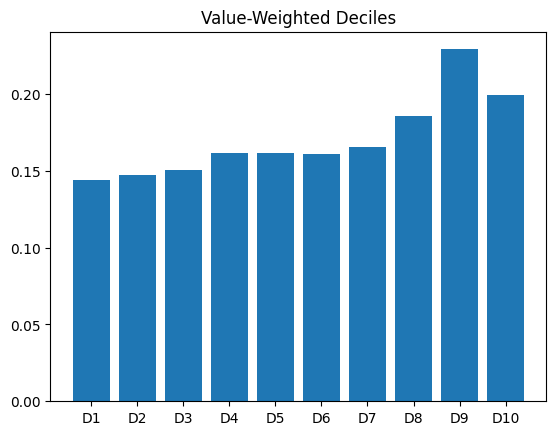

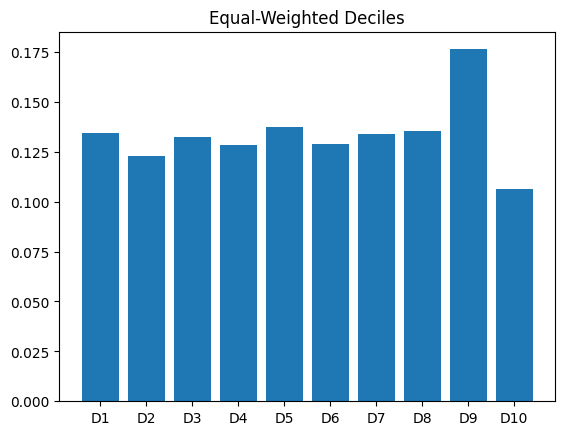

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles'),
 None)

In [24]:
# 5. Plot Histogram
plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_ret_mean*12),plt.title('Value-Weighted Deciles'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_ret_mean*12),plt.title('Equal-Weighted Deciles'), plt.show()

c)

In [25]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0)
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0)

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()

# Levered and unlevered returns
BAB['BAB1'] = BAB['R_L'] - BAB['R_H']
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']



d)

In [26]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0]*12
idio_vol = (tmp['BAB2']-OLS_Reg.predict()).std()*np.sqrt(12)
market_rp = tmp['Rm_e'].mean()*12
market_vol = tmp['Rm_e'].std()*np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor: ', Alpha_bab, OLS_Reg.tvalues[0])
print('Sharpe Ratio of BAB factor: ',tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Idiosyncatic volatility: ',idio_vol)
print('Beta BAB: ',beta_bab)
print('Market Risk Premium: ',market_rp)
print('Market Volatility: ',market_vol)

Annualized Alpha of BAB factor:  0.11846480382496943 6.555918358878368
Sharpe Ratio of BAB factor:  0.7617003507156583
Idiosyncatic volatility:  0.13290362050544063
Beta BAB:  -0.2157029658827404
Market Risk Premium:  0.0644341716450973
Market Volatility:  0.15941410983233564


In [28]:
data.to_parquet('stock_data_part1.parquet')


---
# Momentum Strategy (Mom)

---
# Idiosyncratic Volatility Strategy (IV)

---
# Optimal Fund Portfolio Return (STRAT)

---
# Performance and risk analysis for the Fund strategy

---
# Industry neutral strategy